In [50]:
import numpy as np # linear algebra
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
import hopsworks

In [51]:
project = hopsworks.login()
fs = project.get_feature_store() 

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/4247
Connected. Call `.close()` to terminate connection gracefully.


In [52]:
try: 
    feature_view = fs.get_feature_view(name="new_electricity_data_fv", version=1)
except:
    electricity_data_fg = fs.get_feature_group('new_electricity_data_fg', version=1)
    query = electricity_data_fg.select_all()    
    feature_view = fs.create_feature_view(name="new_electricity_data_fv",
                                        version=1,
                                        description="Read from Feature Group new_electricity_data_fg",
                                        labels=["day_ahead_price"],
                                        query=query)

In [53]:
electricity_data_fg.read()

2023-01-13 14:58:39,081 INFO: USE `id2223_lab1_featurestore`
2023-01-13 14:58:39,634 INFO: SELECT `fg0`.`hydro_water_reservoir` `hydro_water_reservoir`, `fg0`.`nuclear` `nuclear`, `fg0`.`other` `other`, `fg0`.`solar` `solar`, `fg0`.`wind_onshore` `wind_onshore`, `fg0`.`datetime` `datetime`, `fg0`.`day_ahead_price` `day_ahead_price`, `fg0`.`total_load` `total_load`, `fg0`.`temperature` `temperature`
FROM `id2223_lab1_featurestore`.`new_electricity_data_fg_1` `fg0`


,hydro_water_reservoir,nuclear,other,solar,wind_onshore,datetime,day_ahead_price,total_load,temperature
0,1238.0,5401.0,228.0,242.0,151.0,1661515200000,628.10,8442.0,22.9
1,314.0,6336.0,195.0,0.0,1116.0,1651960800000,1.64,6673.0,7.4
2,370.0,4630.0,526.0,135.0,1034.0,1641812400000,54.93,8204.0,2.0
3,1154.0,6992.0,909.0,66.0,451.0,1647154800000,75.63,10840.0,5.0
4,362.0,5699.0,257.0,103.0,849.0,1662566400000,3.18,7351.0,17.0
...,...,...,...,...,...,...,...,...,...
8797,1104.0,5799.0,950.0,0.0,393.0,1672675200000,170.00,12106.0,6.3
8798,552.0,5796.0,585.0,0.0,871.0,1672628400000,50.08,9256.0,7.6
8799,975.0,5799.0,917.0,3.0,256.0,1672653600000,143.35,11828.0,7.0
8800,578.0,5797.0,583.0,0.0,930.0,1672617600000,51.67,9491.0,7.5


In [ ]:
# query_show = electricity_data_fg.show(5)
# col_names = query_show.columns

In [56]:
version, job = feature_view.create_training_data(
    description = 'new electricity price pred train data',
    data_format = 'csv',
    write_options = {"wait_for_job": True}
) # By default, it is materialised to HopsFS
print(job.id) 

Training dataset job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/4247/jobs/named/new_electricity_data_fv_1_1_create_fv_td_13012023135944/executions
17073


In [57]:
# train_data = feature_view.get_training_data(training_dataset_version=1)[0]

,hydro_water_reservoir,nuclear,other,solar,wind_onshore,datetime,total_load,temperature
0,1238.0,5401.0,228.0,242.0,151.0,1661515200000,8442.0,22.9
1,314.0,6336.0,195.0,0.0,1116.0,1651960800000,6673.0,7.4
2,370.0,4630.0,526.0,135.0,1034.0,1641812400000,8204.0,2.0
3,1154.0,6992.0,909.0,66.0,451.0,1647154800000,10840.0,5.0
4,362.0,5699.0,257.0,103.0,849.0,1662566400000,7351.0,17.0
...,...,...,...,...,...,...,...,...
8797,1104.0,5799.0,950.0,0.0,393.0,1672675200000,12106.0,6.3
8798,552.0,5796.0,585.0,0.0,871.0,1672628400000,9256.0,7.6
8799,975.0,5799.0,917.0,3.0,256.0,1672653600000,11828.0,7.0
8800,578.0,5797.0,583.0,0.0,930.0,1672617600000,9491.0,7.5


### Redone with help from peer

In [ ]:
# train_data.set_index('datetime', inplace=True)

In [13]:
# Split into train & test sets
train_size = int(len(train_data) * 0.80)
test_size = len(train_data) - train_size
test = train_data.iloc[train_size:,:]
train = train_data.iloc[0:train_size,:]

In [14]:
train.head()

,hydro_water_reservoir,nuclear,other,solar,wind_onshore,day_ahead_price,total_load,temperature
datetime,,,,,,,,
1661515200000,1238.0,5401.0,228.0,242.0,151.0,628.10,8442.0,22.9
1651960800000,314.0,6336.0,195.0,0.0,1116.0,1.64,6673.0,7.4
1641812400000,370.0,4630.0,526.0,135.0,1034.0,54.93,8204.0,2.0
1647154800000,1154.0,6992.0,909.0,66.0,451.0,75.63,10840.0,5.0
1662566400000,362.0,5699.0,257.0,103.0,849.0,3.18,7351.0,17.0


In [15]:
test.head()

,hydro_water_reservoir,nuclear,other,solar,wind_onshore,day_ahead_price,total_load,temperature
datetime,,,,,,,,
1657000800000,641.0,3927.0,525.0,66.0,1385.0,5.89,7898.0,16.0
1672092000000,494.0,5795.0,737.0,0.0,1948.0,19.48,9677.0,4.5
1657357200000,823.0,4553.0,416.0,275.0,110.0,450.38,8868.0,18.5
1663182000000,352.0,4577.0,343.0,0.0,1069.0,65.06,8587.0,14.8
1668340800000,1038.0,5495.0,510.0,21.0,74.0,38.78,9305.0,12.7


In [16]:
# Standard scaler for features and label

sc_x=StandardScaler()
X_scaled_train=sc_x.fit_transform(train)

In [17]:
sc_y=StandardScaler()
y_scaled_train=sc_y.fit_transform(train[['day_ahead_price']])

In [19]:
train.info()

7041

In [30]:
step_back=24
no_records=len(train)
no_cols=8
X_train=[]
y_train=[]
for i in range(step_back,no_records):
    X_train.append(X_scaled_train[i-step_back:i])
    y_train.append(y_scaled_train[i][0])
X_train,y_train=np.array(X_train),np.array(y_train)

In [31]:
print(X_train.shape)
print(y_train.shape)

(7017, 24, 8)
(7017,)


In [32]:
X_train_shape=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],X_train.shape[2]))
X_train_shape.shape

### LSTM model

In [34]:
model_lstm = Sequential()
model_lstm.add(LSTM(100, input_shape=(step_back,no_cols)))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

2023-01-13 14:21:05.710903: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 14:21:05.711302: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-13 14:21:05.712009: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-01-13 14:21:05.712104: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-01-13 14:21:05.712194: W tensorflow/c

In [35]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               43600     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 43,701
Trainable params: 43,701
Non-trainable params: 0
_________________________________________________________________


In [36]:
model_lstm.fit(X_train_shape, y_train, epochs=200, batch_size=265, verbose=1, shuffle=False)

Epoch 1/200
27/27 [==============================] - 4s 47ms/step - loss: 1.0086
Epoch 2/200
27/27 [==============================] - 1s 50ms/step - loss: 1.0013
Epoch 3/200
27/27 [==============================] - 1s 48ms/step - loss: 0.9995
Epoch 4/200
27/27 [==============================] - 1s 47ms/step - loss: 0.9974
Epoch 5/200
27/27 [==============================] - 1s 53ms/step - loss: 0.9946
Epoch 6/200
27/27 [==============================] - 1s 52ms/step - loss: 0.9924
Epoch 7/200
27/27 [==============================] - 1s 51ms/step - loss: 0.9916
Epoch 8/200
27/27 [==============================] - 1s 51ms/step - loss: 0.9909
Epoch 9/200
27/27 [==============================] - 2s 60ms/step - loss: 0.9880
Epoch 10/200
27/27 [==============================] - 2s 61ms/step - loss: 0.9881
Epoch 11/200
27/27 [==============================] - 2s 62ms/step - loss: 0.9831
Epoch 12/200
27/27 [==============================] - 2s 62ms/step - loss: 0.9815
Epoch 13/200
27/27 [=====

In [37]:
last_24=train.iloc[-step_back:]
full_df= pd.concat((last_24,test),axis=0)
print(full_df.shape)
full_df.head()

(1785, 8)


,hydro_water_reservoir,nuclear,other,solar,wind_onshore,day_ahead_price,total_load,temperature
datetime,,,,,,,,
1664190000000,584.0,4616.0,549.0,76.0,784.0,169.76,9341.0,13.0
1667318400000,1503.0,6391.0,1348.0,0.0,1670.0,173.63,14608.0,13.3
1650513600000,953.0,5519.0,699.0,11.0,1237.0,66.75,9026.0,8.9
1654614000000,651.0,6118.0,346.0,181.0,1338.0,171.79,8662.0,16.2
1643810400000,1539.0,6986.0,1200.0,7.0,187.0,188.46,13944.0,-0.1


In [38]:
full_df=sc_x.transform(full_df)
full_df.shape

(1785, 8)

In [40]:
step_back=step_back
no_records=len(full_df)
no_cols=no_cols
X_train_shape_pred=[]
for i in range(step_back,no_records):
    X_train_shape_pred.append(full_df[i-step_back:i])
X_train_shape_pred=np.array(X_train_shape_pred)
print(X_train_shape_pred.shape)

(1761, 24, 8)


In [41]:
y_test=model_lstm.predict(X_train_shape_pred)

56/56 [==============================] - 1s 6ms/step


In [42]:
y_final_pred=sc_y.inverse_transform(y_test)
y_final_pred

array([[135.74431],
       [118.85593],
       [160.33336],
       ...,
       [174.30989],
       [237.3684 ],
       [391.1784 ]], dtype=float32)

In [43]:
final_pred=pd.DataFrame(y_final_pred)
final_pred.columns=['final_pred']
final_pred.head()

,final_pred
0,135.744308
1,118.855927
2,160.333359
3,58.206657
4,8.916784


In [44]:
test.reset_index(inplace=True)

In [45]:
fully_final=pd.concat((final_pred,test),axis=1)
fully_final

,final_pred,datetime,hydro_water_reservoir,nuclear,other,solar,wind_onshore,day_ahead_price,total_load,temperature
0,135.744308,1657000800000,641.0,3927.0,525.0,66.0,1385.0,5.89,7898.0,16.0
1,118.855927,1672092000000,494.0,5795.0,737.0,0.0,1948.0,19.48,9677.0,4.5
2,160.333359,1657357200000,823.0,4553.0,416.0,275.0,110.0,450.38,8868.0,18.5
3,58.206657,1663182000000,352.0,4577.0,343.0,0.0,1069.0,65.06,8587.0,14.8
4,8.916784,1668340800000,1038.0,5495.0,510.0,21.0,74.0,38.78,9305.0,12.7
...,...,...,...,...,...,...,...,...,...,...
1756,35.553268,1672675200000,1104.0,5799.0,950.0,0.0,393.0,170.00,12106.0,6.3
1757,37.980438,1672628400000,552.0,5796.0,585.0,0.0,871.0,50.08,9256.0,7.6
1758,174.309891,1672653600000,975.0,5799.0,917.0,3.0,256.0,143.35,11828.0,7.0
1759,237.368393,1672617600000,578.0,5797.0,583.0,0.0,930.0,51.67,9491.0,7.5


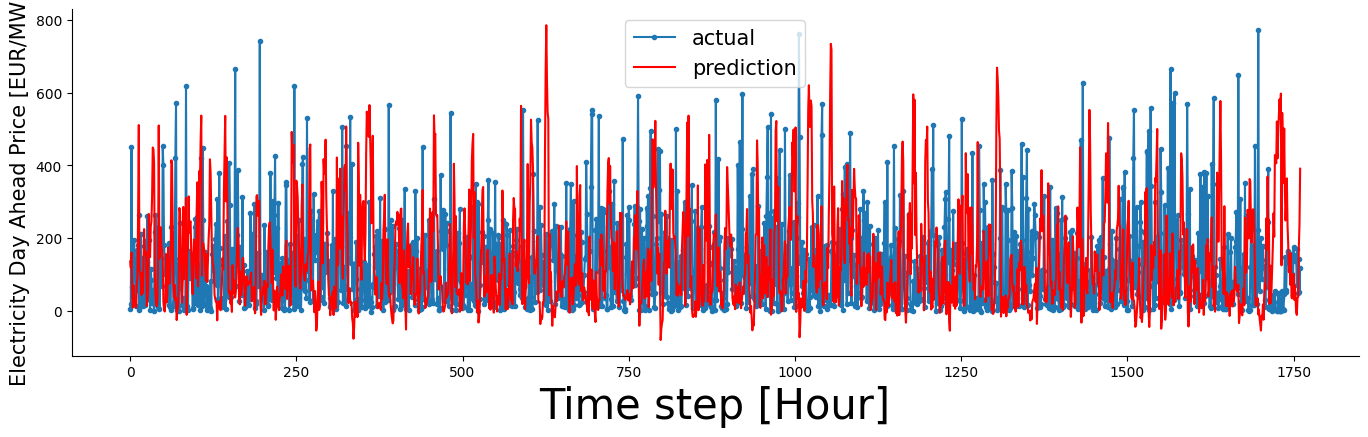

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
aa=[x for x in range(1761)]
plt.figure(figsize=(14,4))
plt.plot(aa, fully_final['day_ahead_price'], marker='.', label="actual")
plt.plot(aa, fully_final['final_pred'], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Electricity Day Ahead Price [EUR/MWh]', size=15)
plt.xlabel('Time step [Hour]', size=30)
plt.legend(fontsize=15)
plt.show();

### Upload model to hopsworks

In [ ]:
import hopsworks

project = hopsworks.login() 
fs = project.get_feature_store() 
mr = project.get_model_registry()

In [ ]:
model = mr.sklearn.create_model(
    name="lstm_model",
    description="LSTM test.",
)

model.save('/content/first_model.pickle')